In [1]:
# Initialisation(s)

import os, sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # Running in Google CoLab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    global_prefix = '/content/gdrive/MyDrive/Colab Notebooks/Jupyter-Puzzles/python/solitaire/'
    os.chdir(global_prefix)
else:
    # Not running in Google CoLab
    global_prefix = os.getcwd().replace('\\','/') + '/'

sys.path.append(f'{global_prefix}../outils')
import displayImages

%run ../outils/parcours.ipynb

# Solitaire

## Objet du problème

Résoudre un [solitaire](https://fr.wikipedia.org/wiki/Solitaire_(casse-t%C3%AAte)), par exemple le solitaire anglais et le solitaire français ou européen (plus difficile).

## Calcul d'une solution
On utilise un [parcours en profondeur](../outils/parcours.ipynb).

Un état est un couple  (*board*, *n*) où *board* est un tuple de tuples d'entiers comme par exemple `english_board` ou`french_board` ci-dessous ; et *n* est le nombre de 1 dans *board*.

Une action est un couple de couples d'entiers ((*from_x*, *from_y*), (*to_x*, *to_y*)).

Les fonctions `legal_actions` et  `delta` sont largement empruntées à [solving-peg-solitaire](https://blog.c-01a.de/posts/solving-peg-solitaire)

In [2]:
# 0 = empty, 1 = occupied, 2 = invalid

english_board = (
    (2, 2, 1, 1, 1, 2, 2),
    (2, 2, 1, 1, 1, 2, 2),
    (1, 1, 1, 1, 1, 1, 1),
    (1, 1, 1, 0, 1, 1, 1),
    (1, 1, 1, 1, 1, 1, 1),
    (2, 2, 1, 1, 1, 2, 2),
    (2, 2, 1, 1, 1, 2, 2),
)

french_board = (
    (2, 2, 1, 1, 1, 2, 2),
    (2, 1, 1, 0, 1, 1, 2),
    (1, 1, 1, 1, 1, 1, 1),
    (1, 1, 1, 1, 1, 1, 1),
    (1, 1, 1, 1, 1, 1, 1),
    (2, 1, 1, 1, 1, 1, 2),
    (2, 2, 1, 1, 1, 2, 2),
)

german_board = (
    (2, 2, 2, 1, 1, 1, 2, 2, 2),
    (2, 2, 2, 1, 1, 1, 2, 2, 2),
    (2, 2, 2, 1, 1, 1, 2, 2, 2),
    (1, 1, 1, 1, 1, 1, 1, 1, 1),
    (1, 1, 1, 1, 0, 1, 1, 1, 1),
    (1, 1, 1, 1, 1, 1, 1, 1, 1),
    (2, 2, 2, 1, 1, 1, 2, 2, 2),
    (2, 2, 2, 1, 1, 1, 2, 2, 2),
    (2, 2, 2, 1, 1, 1, 2, 2, 2),
)

def dims(board): # height, width
    return (len(board), len(board[0]))

def delta(state, action):
    (from_x, from_y), (to_x, to_y) = action
    board = [[peg for peg in row] for row in state]

    # Delete peg from old position
    board[from_x][from_y] = 0
    # Place peg at new position
    board[to_x][to_y] = 1
    # Delete peg in between
    board[(from_x + to_x) // 2][(from_y + to_y) // 2] = 0

    newState = tuple(map(lambda x: tuple(x),board))
    return newState

def nb_pegs(board):
    count = 0
    for peg in [p for row in board for p in row]:
            count += 1 if peg == 1 else 0
    return count

def solve(initial_board, final = None):

    height, width = dims(initial_board)

    initial_count = nb_pegs(initial_board)

    start_state = (initial_board, initial_count)

    def is_end_state(state):
        if final is None:
            return state[1] == 1
        else:
            return state[1] == 1 and state[0][final[0]][final[1]] == 1

    def actions_for_peg(board, x, y):

        peg_actions = []

        # x, y offsets for actions towards top, bottom, left, and right
        action_offsets = [(-2, 0), (2, 0), (0, -2), (0, 2)]

        for (dx, dy) in action_offsets:
            new_x = x + dx
            new_y = y + dy

            # If new position is inside the board
            if 0 <= new_x < height and 0 <= new_y < width:
                # If the new position is free
                if board[new_x][new_y] == 0:
                    # If there is a peg next to the current peg in the action's direction
                    if board[(x + new_x) // 2][(y + new_y) // 2] == 1:
                        peg_actions.append((new_x, new_y))

        return peg_actions

    def legal_actions(state):
        actions = []  # Format: ((from x, from y), (to x, to y))

        # For each board position
        for x, row in enumerate(state[0]):
            for y, peg in enumerate(row):
                # If occupied by a peg
                if peg == 1:
                    # Find valid actionss for this peg
                    peg_actions = actions_for_peg(state[0],x, y)

                    actions.extend([((x, y), action) for action in peg_actions])
        return tuple(actions)

    return dfs(start_state, is_end_state, legal_actions, delta = lambda state, action: (delta(state[0], action), state[1] - 1))

## Affichage

### Affichage graphique du plateau

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def imBoard(board, move = None):

    height = len(board)

    matplotlib.rcParams['toolbar'] = 'None'
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.axis('equal')
    for i,l in enumerate(board):
        for j,v in enumerate(l):
            x,y = j + .5, height - .5 - i
            if v == 0:
                ax.add_patch(plt.Circle((x,y),.25, lw = 2., ec = 'lightslategray', fill = False))
            elif v == 1:
                ax.add_patch(plt.Circle((x,y),.25, lw = 2., ec = 'lightslategray', fc = 'lightsteelblue'))
    if move:
        (i1,j1),(i2,j2) = move
        x1,y1,x2,y2 = j1 + .5, height - .5 - i1,j2 + .5, height - .5 - i2
        ax.add_patch(plt.arrow(x1,y1,x2-x1,y2-y1))
        ax.add_patch(plt.arrow(x1,y1,x2-x1,y2-y1,
                               width = .05,
                               head_width = .25,
                               head_length = .35,
                               length_includes_head = True,
                               ec = 'dimgray'))
    ax.plot()
    plt.close()
    return displayImages.fig2im(fig)


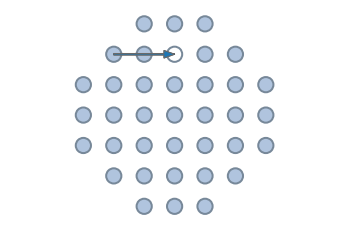

In [4]:
imBoard(french_board, move = ((1, 1), (1, 3)))

### Affichage d'une solution

In [5]:
def imsSol(state, sol):
    l = []
    for action in sol:
        l.append(imBoard(state, move = action))
        state = delta(state,action)
    l.append(imBoard(state))
    return l

#! mkdir images
def writeSol(ims, prefix):
    for i, im in enumerate(ims):
        im.save(f'{global_prefix}images/{prefix}-{i}.png', format = 'png')

def displaySol(prefix):
    display_images = displayImages.mpl if IN_COLAB else displayImages.cv # ou widgets
    return display_images(f'{global_prefix}images/{prefix}-')

#### Solitaire anglais

In [17]:
english_sol = solve(english_board, final = (3,3)) # 0.5 s
english_ims = imsSol(english_board, english_sol)
writeSol(english_ims, 'english')

In [21]:
displaySol('english')

#### Solitaire français

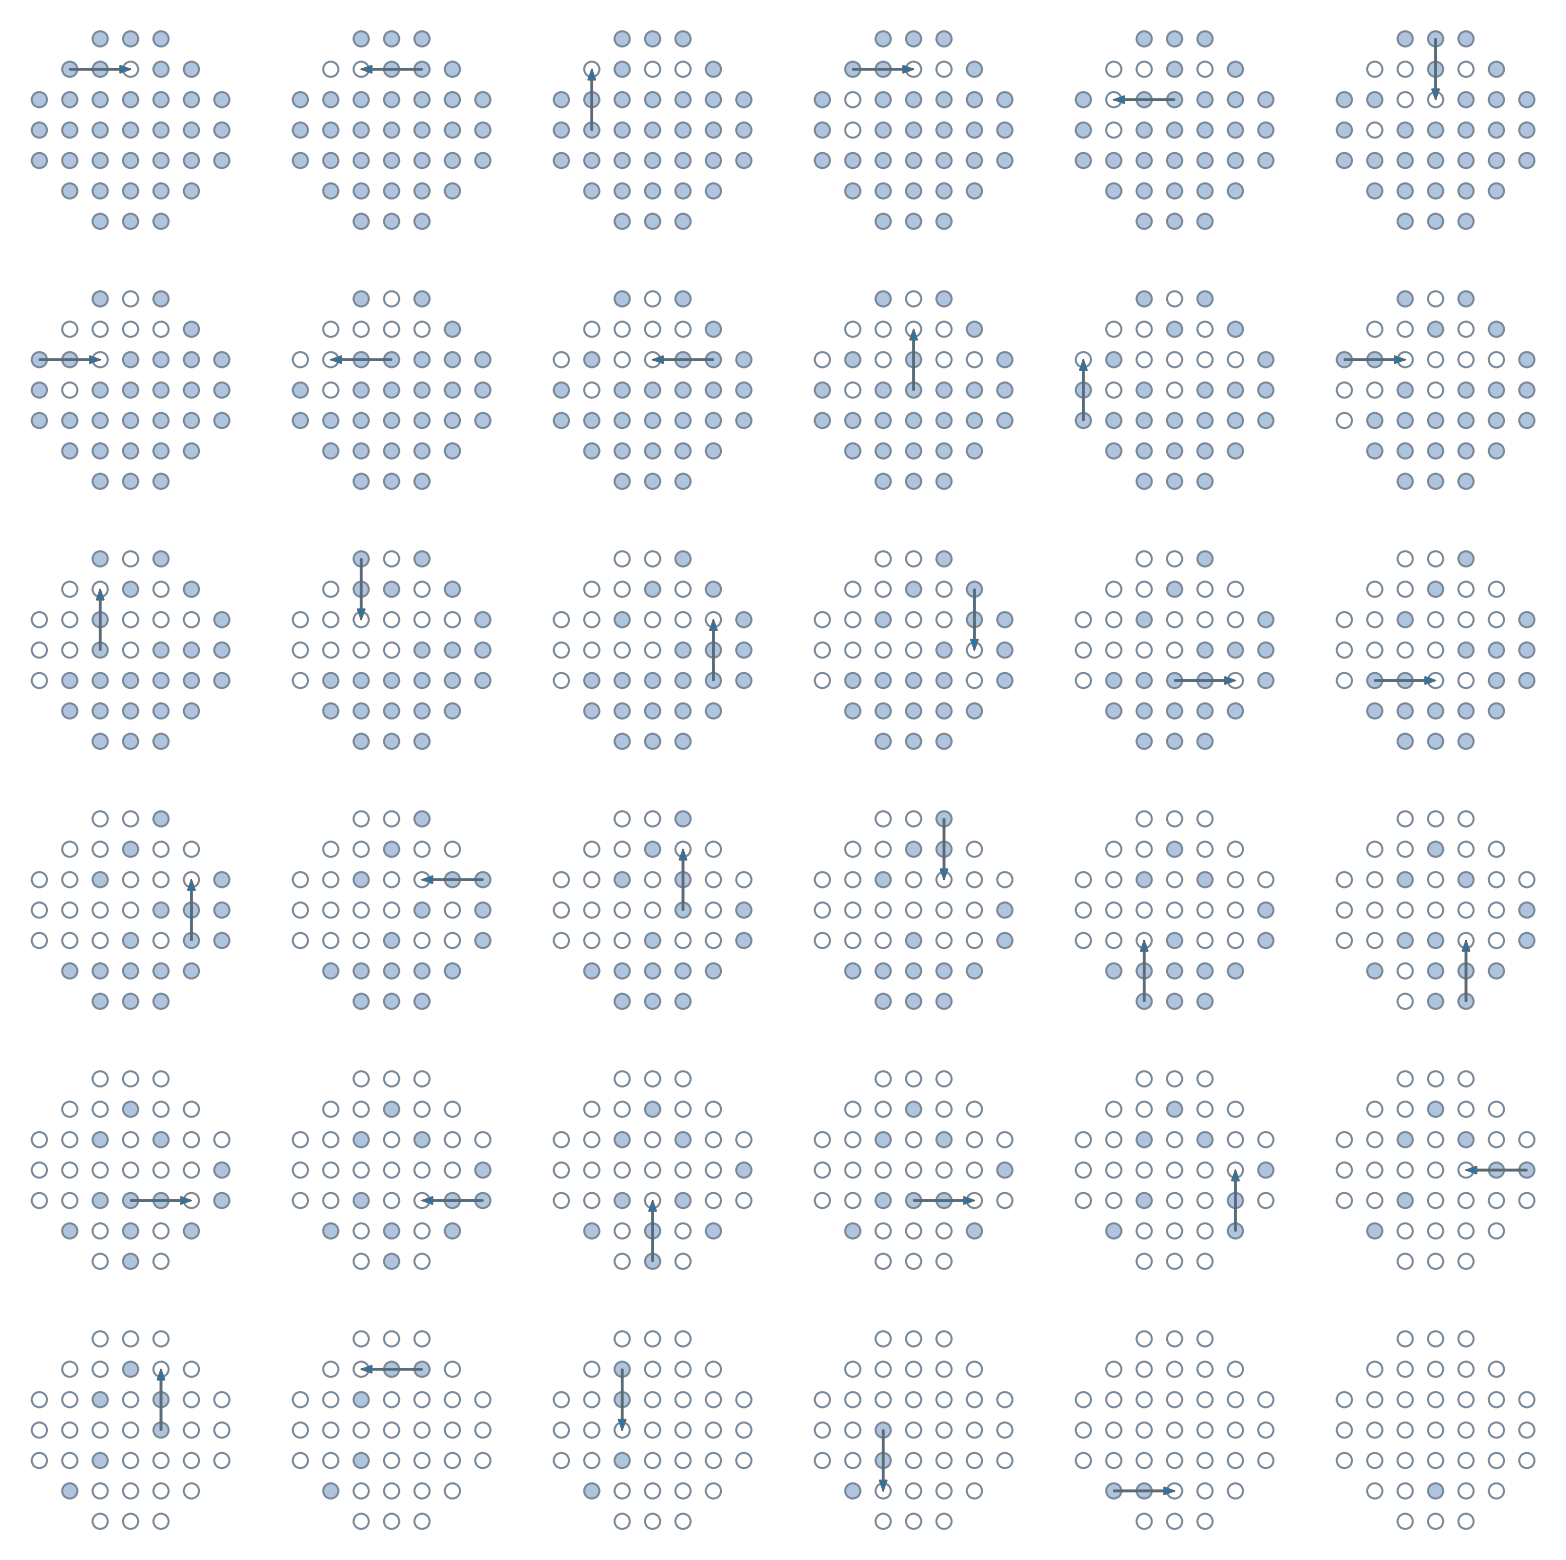

In [6]:
french_sol = solve(french_board) # 2 mn
french_ims = imsSol(french_board, french_sol)
writeSol(french_ims, 'french')
displayImages.concat(french_ims, nbColonnes=6, border = 30)

In [7]:
displaySol('french')

#### Solitaire allemand

In [ ]:
german_sol = solve(german_board, final = (4,4)) # 2 h
german_ims = imsSol(german_board, german_sol)
writeSol(german_ims, 'german')

In [30]:
displaySol('german')